In [1]:
!pip install transformers

In [ ]:
import re
import time
import string
import pickle
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm, notebook
import pickle
from joblib import dump
from sklearn.model_selection import train_test_split

from keras.layers import Dense, GlobalMaxPooling1D, Dropout, Dense, BatchNormalization, Input
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM,Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn import datasets, svm
import matplotlib.pyplot as plt

In [230]:
import numpy as np
import pandas as pd
import pylab as plt
import matplotlib.pyplot as plt

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import cohen_kappa_score

import tensorflow
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras import optimizers
from keras.optimizers import Adam


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pickle
import seaborn as sns

from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords

import keras
import io
import requests
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from underthesea import word_tokenize

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from keras import backend as K

import codecs

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15221895974790539851
xla_global_id: -1
]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**load data**

In [390]:
df = pd.read_csv('Data_DS307_1.csv')

In [391]:
NUM_CLASSES = len(df['label'].unique())
index2class = {0:'Không hài lòng', 1:'Hài lòng'}
class2index = {"Không hài lòng": 0, "Hài lòng":1}

In [392]:
df.label

0              Hài lòng
1              Hài lòng
2              Hài lòng
3              Hài lòng
4              Hài lòng
              ...      
11702    Không hài lòng
11703          Hài lòng
11704    Không hài lòng
11705          Hài lòng
11706          Hài lòng
Name: label, Length: 11707, dtype: object

In [393]:
df.label = df.label.map(lambda x : class2index[x])

In [394]:
text = df.content.to_list()
label = df.label.to_list()

text_ = []
label_ = []

dict_count = {1 : 1, 0 : 1}

for i in range(len(text)):
    if dict_count[label[i]] <= 2500:
       text_.append(text[i])
       label_.append(label[i])
       dict_count[label[i]] += 1

In [395]:
text = text_
label = label_

**pho_bert**

In [396]:
def load_bert():
    v_phobert = AutoModel.from_pretrained("vinai/phobert-base")
    v_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
    return v_phobert, v_tokenizer
phobert, tokenizer = load_bert()

In [397]:
def phobert_embed_sentence(padded, mask, model=phobert):
    # embed a single setence data
    # param padded: a tokenized, padded sentence
    # param mask: an attention mask of the padded sentence
    padded = torch.tensor(padded).to(torch.long)
    mask = torch.tensor(mask)
    with torch.no_grad():
        last_hidden_states = model(input_ids=padded, attention_mask=mask)[0]
    vector = last_hidden_states[:, 0, :].numpy() # [:,0,:] to get embedding vector of the first output token [CLS]
    return vector.flatten()

def phobert_embed_data(data, tokenizer=tokenizer):
    # embed the whole dataset with phobert
    # param padded_data: tokenized, padded dataset
    # param mask_data: attention masks of the padded dataset
    MAX_LENGTH = tokenizer.model_max_length # phobert default max sequence length = 256

    embedded_data = np.array([])
    for line in tqdm(data):
        tokenized_line = tokenizer.encode(line, max_length=MAX_LENGTH, truncation=True)
        # pad sentence to a pre-defined max length, no truncating since it is already truncated in the phobert tokenizing
        padded_line = pad_sequences([tokenized_line], maxlen=MAX_LENGTH, padding='post', value=1)
        # Get attention mask from padded sentence of data to make PhoBERT focus on non-padded data only
        # pad tokenized sentence with value = 1, since 1 is pre-defined padding value of PhoBERT
        mask = np.where(padded_line == 1, 0, 1)

        embedded_line = phobert_embed_sentence(padded_line, mask)
        
        if embedded_data.shape[0] == 0:
            embedded_data = np.empty((0, embedded_line.shape[0]), 'float32')
            
        embedded_data = np.concatenate((embedded_data, [embedded_line]))
    return embedded_data

In [398]:
phobert_train = phobert_embed_data(text)

100%|██████████| 5000/5000 [33:06<00:00,  2.52it/s]


In [399]:
np.savetxt('PhoBert/PhoBertEmbedding.txt', phobert_train)

In [400]:
dump(label,'PhoBert/label.pkl')

['PhoBert/label.pkl']

In [401]:
X_train, X_test, y_train, y_test = train_test_split(phobert_train, label, test_size=0.15, random_state=0)

In [402]:
X_train[0].shape

(768,)

**LSTM**

In [403]:
y_train = pd.get_dummies(y_train)
X_train = np.expand_dims(X_train,axis = 1)

In [404]:
MAX_EPOCHS = 200

checkpoint_path = "PhoBert/"

model_LSTM = tf.keras.Sequential([
    tf.keras.layers.LSTM(128,return_sequences = True,input_shape = (1,768)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(128,return_sequences = False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(2,activation='softmax')  
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=50,
                                                  mode='min',
                                                  restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path + 'LSTM', monitor='val_loss', save_best_only=True, save_feq='epoch')
model_LSTM.compile(optimizer='adam',loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [405]:
model_LSTM.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 128)            459264    
                                                                 
 dropout_12 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_13 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 32)                4128      
                                                                 
 dense_27 (Dense)            (None, 2)                 66        
                                                                 
Total params: 595,042
Trainable params: 595,042
Non-t

In [406]:
history = model_LSTM.fit(np.array(X_train),np.array(y_train),validation_split=0.2, epochs=200,batch_size = 32, callbacks=[early_stopping,model_checkpoint])

Epoch 1/200
107/107 [==============================] - ETA: 0s - loss: 0.4457 - accuracy: 0.7965

INFO:tensorflow:Assets written to: PhoBert\LSTM\assets


INFO:tensorflow:Assets written to: PhoBert\LSTM\assets


107/107 [==============================] - 19s 126ms/step - loss: 0.4457 - accuracy: 0.7965 - val_loss: 0.3107 - val_accuracy: 0.8765
Epoch 2/200
107/107 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.8626

INFO:tensorflow:Assets written to: PhoBert\LSTM\assets


INFO:tensorflow:Assets written to: PhoBert\LSTM\assets


107/107 [==============================] - 13s 127ms/step - loss: 0.3299 - accuracy: 0.8626 - val_loss: 0.2831 - val_accuracy: 0.8894
Epoch 3/200
104/107 [============================>.] - ETA: 0s - loss: 0.2917 - accuracy: 0.8855

INFO:tensorflow:Assets written to: PhoBert\LSTM\assets


INFO:tensorflow:Assets written to: PhoBert\LSTM\assets


107/107 [==============================] - 11s 99ms/step - loss: 0.2902 - accuracy: 0.8856 - val_loss: 0.2684 - val_accuracy: 0.8894
Epoch 4/200
106/107 [============================>.] - ETA: 0s - loss: 0.2619 - accuracy: 0.9006

INFO:tensorflow:Assets written to: PhoBert\LSTM\assets


INFO:tensorflow:Assets written to: PhoBert\LSTM\assets


107/107 [==============================] - 12s 114ms/step - loss: 0.2615 - accuracy: 0.9009 - val_loss: 0.2611 - val_accuracy: 0.8976
Epoch 5/200
107/107 [==============================] - 3s 24ms/step - loss: 0.2448 - accuracy: 0.9053 - val_loss: 0.2767 - val_accuracy: 0.8906
Epoch 6/200
107/107 [==============================] - 3s 26ms/step - loss: 0.2167 - accuracy: 0.9088 - val_loss: 0.2802 - val_accuracy: 0.8953
Epoch 7/200
107/107 [==============================] - 3s 29ms/step - loss: 0.1854 - accuracy: 0.9309 - val_loss: 0.2911 - val_accuracy: 0.8871
Epoch 8/200
107/107 [==============================] - 3s 25ms/step - loss: 0.1724 - accuracy: 0.9329 - val_loss: 0.2941 - val_accuracy: 0.8953
Epoch 9/200
107/107 [==============================] - 3s 28ms/step - loss: 0.1569 - accuracy: 0.9400 - val_loss: 0.2881 - val_accuracy: 0.8988
Epoch 10/200
107/107 [==============================] - 2s 22ms/step - loss: 0.1435 - accuracy: 0.9468 - val_loss: 0.2709 - val_accuracy: 0.8988
E

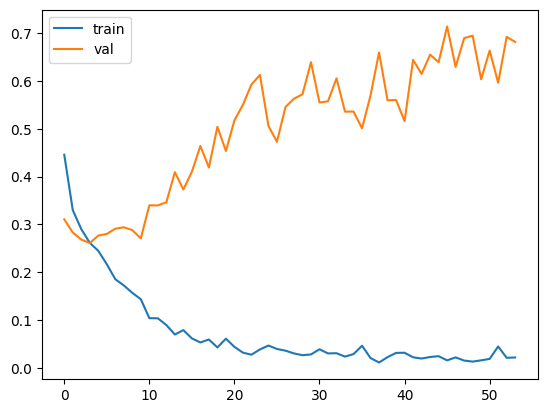

In [409]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

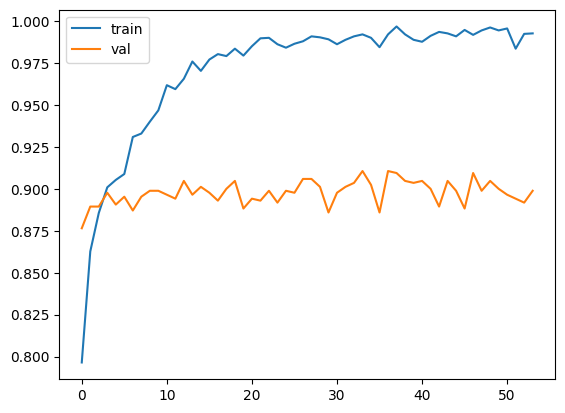

In [410]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()

In [411]:
model_LSTM.evaluate(np.array(np.expand_dims(X_test,1)),np.array(pd.get_dummies(y_test)))

24/24 [==============================] - 0s 6ms/step - loss: 0.2687 - accuracy: 0.8960


[0.268676221370697, 0.8960000276565552]

In [260]:
model_LSTM.save('model_LSTM_DS307.h5')

**CNN**

In [282]:
X_train, X_test, y_train, y_test = train_test_split(phobert_train, label, test_size=0.15, random_state=0)

In [283]:
X_train = np.expand_dims(X_train,-1)

In [296]:
CNN_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 764, 128)          768       
                                                                 
 conv1d_3 (Conv1D)           (None, 762, 64)           24640     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 3)                 99        
                                                                 
Total params: 27,587
Trainable params: 27,587
Non-trainable params: 0
_________________________________________________

In [284]:
CNN_model = tf.keras.models.Sequential([
              Conv1D(128, kernel_size=5, input_shape=(768,1)),
              Conv1D(64, kernel_size=3, activation='relu'),
              GlobalMaxPooling1D(),
              Dense(32, activation='relu'),
              Dense(3, activation='softmax')                            
            ])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path + 'CNN', monitor='val_loss', save_best_only=True, save_feq='epoch')
CNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_CNN = CNN_model.fit(np.array(X_train),np.array(y_train), epochs=100, verbose=1, validation_split=0.2,callbacks=[early_stopping,model_checkpoint])

Epoch 1/100
106/107 [============================>.] - ETA: 0s - loss: 0.7357 - accuracy: 0.5342

INFO:tensorflow:Assets written to: PhoBert\CNN\assets


INFO:tensorflow:Assets written to: PhoBert\CNN\assets


107/107 [==============================] - 8s 68ms/step - loss: 0.7358 - accuracy: 0.5338 - val_loss: 0.6712 - val_accuracy: 0.5612
Epoch 2/100
106/107 [============================>.] - ETA: 0s - loss: 0.6627 - accuracy: 0.5991

INFO:tensorflow:Assets written to: PhoBert\CNN\assets


INFO:tensorflow:Assets written to: PhoBert\CNN\assets


107/107 [==============================] - 8s 73ms/step - loss: 0.6628 - accuracy: 0.5985 - val_loss: 0.6335 - val_accuracy: 0.6588
Epoch 3/100
106/107 [============================>.] - ETA: 0s - loss: 0.6375 - accuracy: 0.6421

INFO:tensorflow:Assets written to: PhoBert\CNN\assets


INFO:tensorflow:Assets written to: PhoBert\CNN\assets


107/107 [==============================] - 8s 73ms/step - loss: 0.6372 - accuracy: 0.6426 - val_loss: 0.6206 - val_accuracy: 0.6576
Epoch 4/100
107/107 [==============================] - 7s 66ms/step - loss: 0.6278 - accuracy: 0.6471 - val_loss: 0.6620 - val_accuracy: 0.5812
Epoch 5/100
106/107 [============================>.] - ETA: 0s - loss: 0.6162 - accuracy: 0.6560

INFO:tensorflow:Assets written to: PhoBert\CNN\assets


INFO:tensorflow:Assets written to: PhoBert\CNN\assets


107/107 [==============================] - 7s 70ms/step - loss: 0.6163 - accuracy: 0.6556 - val_loss: 0.6025 - val_accuracy: 0.6753
Epoch 6/100
107/107 [==============================] - ETA: 0s - loss: 0.6065 - accuracy: 0.6762

INFO:tensorflow:Assets written to: PhoBert\CNN\assets


INFO:tensorflow:Assets written to: PhoBert\CNN\assets


107/107 [==============================] - 9s 80ms/step - loss: 0.6065 - accuracy: 0.6762 - val_loss: 0.5823 - val_accuracy: 0.7035
Epoch 7/100
106/107 [============================>.] - ETA: 0s - loss: 0.5858 - accuracy: 0.6896

INFO:tensorflow:Assets written to: PhoBert\CNN\assets


INFO:tensorflow:Assets written to: PhoBert\CNN\assets


107/107 [==============================] - 8s 76ms/step - loss: 0.5859 - accuracy: 0.6894 - val_loss: 0.5798 - val_accuracy: 0.6906
Epoch 8/100
107/107 [==============================] - 8s 77ms/step - loss: 0.5809 - accuracy: 0.6941 - val_loss: 0.6066 - val_accuracy: 0.6588
Epoch 9/100
106/107 [============================>.] - ETA: 0s - loss: 0.5745 - accuracy: 0.6937

INFO:tensorflow:Assets written to: PhoBert\CNN\assets


INFO:tensorflow:Assets written to: PhoBert\CNN\assets


107/107 [==============================] - 7s 70ms/step - loss: 0.5739 - accuracy: 0.6941 - val_loss: 0.5638 - val_accuracy: 0.7153
Epoch 10/100
107/107 [==============================] - 8s 75ms/step - loss: 0.5784 - accuracy: 0.6885 - val_loss: 0.5672 - val_accuracy: 0.7165
Epoch 11/100
107/107 [==============================] - 7s 65ms/step - loss: 0.5653 - accuracy: 0.7000 - val_loss: 0.5651 - val_accuracy: 0.7106
Epoch 12/100
107/107 [==============================] - 8s 72ms/step - loss: 0.5693 - accuracy: 0.7021 - val_loss: 0.5647 - val_accuracy: 0.7059
Epoch 13/100
107/107 [==============================] - 7s 69ms/step - loss: 0.5965 - accuracy: 0.6776 - val_loss: 0.5814 - val_accuracy: 0.6800
Epoch 14/100
107/107 [==============================] - 9s 83ms/step - loss: 0.5656 - accuracy: 0.7056 - val_loss: 0.5676 - val_accuracy: 0.6941
Epoch 15/100
106/107 [============================>.] - ETA: 0s - loss: 0.5541 - accuracy: 0.7078

INFO:tensorflow:Assets written to: PhoBert\CNN\assets


INFO:tensorflow:Assets written to: PhoBert\CNN\assets


107/107 [==============================] - 8s 77ms/step - loss: 0.5540 - accuracy: 0.7079 - val_loss: 0.5566 - val_accuracy: 0.7176
Epoch 16/100
107/107 [==============================] - 8s 79ms/step - loss: 0.5597 - accuracy: 0.7103 - val_loss: 0.5802 - val_accuracy: 0.6835
Epoch 17/100
107/107 [==============================] - 7s 66ms/step - loss: 0.5579 - accuracy: 0.7059 - val_loss: 0.6235 - val_accuracy: 0.6576
Epoch 18/100
107/107 [==============================] - 8s 73ms/step - loss: 0.5448 - accuracy: 0.7276 - val_loss: 0.5837 - val_accuracy: 0.6859
Epoch 19/100
107/107 [==============================] - 7s 63ms/step - loss: 0.5607 - accuracy: 0.7009 - val_loss: 0.5587 - val_accuracy: 0.7176
Epoch 20/100
106/107 [============================>.] - ETA: 0s - loss: 0.5496 - accuracy: 0.7140

INFO:tensorflow:Assets written to: PhoBert\CNN\assets


INFO:tensorflow:Assets written to: PhoBert\CNN\assets


107/107 [==============================] - 9s 87ms/step - loss: 0.5499 - accuracy: 0.7135 - val_loss: 0.5545 - val_accuracy: 0.7141
Epoch 21/100
106/107 [============================>.] - ETA: 0s - loss: 0.5362 - accuracy: 0.7264

INFO:tensorflow:Assets written to: PhoBert\CNN\assets


INFO:tensorflow:Assets written to: PhoBert\CNN\assets


107/107 [==============================] - 7s 69ms/step - loss: 0.5362 - accuracy: 0.7262 - val_loss: 0.5462 - val_accuracy: 0.7200
Epoch 22/100
107/107 [==============================] - 8s 75ms/step - loss: 0.5527 - accuracy: 0.7200 - val_loss: 0.5470 - val_accuracy: 0.7212
Epoch 23/100
107/107 [==============================] - 8s 73ms/step - loss: 0.5355 - accuracy: 0.7256 - val_loss: 0.5738 - val_accuracy: 0.6941
Epoch 24/100
107/107 [==============================] - 9s 81ms/step - loss: 0.5342 - accuracy: 0.7338 - val_loss: 0.6156 - val_accuracy: 0.6682
Epoch 25/100
106/107 [============================>.] - ETA: 0s - loss: 0.5221 - accuracy: 0.7426

INFO:tensorflow:Assets written to: PhoBert\CNN\assets


INFO:tensorflow:Assets written to: PhoBert\CNN\assets


107/107 [==============================] - 7s 69ms/step - loss: 0.5222 - accuracy: 0.7426 - val_loss: 0.5451 - val_accuracy: 0.7306
Epoch 26/100
107/107 [==============================] - 7s 69ms/step - loss: 0.5191 - accuracy: 0.7374 - val_loss: 0.5553 - val_accuracy: 0.7071
Epoch 27/100
106/107 [============================>.] - ETA: 0s - loss: 0.5201 - accuracy: 0.7420

INFO:tensorflow:Assets written to: PhoBert\CNN\assets


INFO:tensorflow:Assets written to: PhoBert\CNN\assets


107/107 [==============================] - 7s 62ms/step - loss: 0.5202 - accuracy: 0.7424 - val_loss: 0.5436 - val_accuracy: 0.7353
Epoch 28/100
107/107 [==============================] - 7s 63ms/step - loss: 0.5197 - accuracy: 0.7497 - val_loss: 0.6006 - val_accuracy: 0.6812
Epoch 29/100
107/107 [==============================] - 7s 63ms/step - loss: 0.5255 - accuracy: 0.7382 - val_loss: 0.6295 - val_accuracy: 0.6671
Epoch 30/100
107/107 [==============================] - 6s 60ms/step - loss: 0.5164 - accuracy: 0.7409 - val_loss: 0.5622 - val_accuracy: 0.7212
Epoch 31/100
107/107 [==============================] - 7s 67ms/step - loss: 0.5242 - accuracy: 0.7391 - val_loss: 0.6292 - val_accuracy: 0.6647
Epoch 32/100
106/107 [============================>.] - ETA: 0s - loss: 0.5311 - accuracy: 0.7279

INFO:tensorflow:Assets written to: PhoBert\CNN\assets


INFO:tensorflow:Assets written to: PhoBert\CNN\assets


107/107 [==============================] - 12s 113ms/step - loss: 0.5312 - accuracy: 0.7276 - val_loss: 0.5309 - val_accuracy: 0.7306
Epoch 33/100
107/107 [==============================] - 11s 106ms/step - loss: 0.5086 - accuracy: 0.7453 - val_loss: 0.5404 - val_accuracy: 0.7294
Epoch 34/100
107/107 [==============================] - 11s 104ms/step - loss: 0.5071 - accuracy: 0.7459 - val_loss: 0.5348 - val_accuracy: 0.7341
Epoch 35/100
107/107 [==============================] - 9s 88ms/step - loss: 0.5131 - accuracy: 0.7409 - val_loss: 0.6260 - val_accuracy: 0.6588
Epoch 36/100
107/107 [==============================] - 10s 93ms/step - loss: 0.5215 - accuracy: 0.7341 - val_loss: 0.5367 - val_accuracy: 0.7353
Epoch 37/100
107/107 [==============================] - 10s 91ms/step - loss: 0.5359 - accuracy: 0.7312 - val_loss: 0.6483 - val_accuracy: 0.6647
Epoch 38/100
107/107 [==============================] - 9s 80ms/step - loss: 0.4978 - accuracy: 0.7615 - val_loss: 0.5716 - val_accurac

INFO:tensorflow:Assets written to: PhoBert\CNN\assets


INFO:tensorflow:Assets written to: PhoBert\CNN\assets


107/107 [==============================] - 10s 90ms/step - loss: 0.4758 - accuracy: 0.7682 - val_loss: 0.5250 - val_accuracy: 0.7329
Epoch 51/100
107/107 [==============================] - 10s 91ms/step - loss: 0.4846 - accuracy: 0.7591 - val_loss: 0.5275 - val_accuracy: 0.7424
Epoch 52/100
107/107 [==============================] - 9s 85ms/step - loss: 0.4769 - accuracy: 0.7706 - val_loss: 0.5274 - val_accuracy: 0.7365
Epoch 53/100
106/107 [============================>.] - ETA: 0s - loss: 0.4713 - accuracy: 0.7721

INFO:tensorflow:Assets written to: PhoBert\CNN\assets


INFO:tensorflow:Assets written to: PhoBert\CNN\assets


107/107 [==============================] - 10s 97ms/step - loss: 0.4713 - accuracy: 0.7721 - val_loss: 0.5250 - val_accuracy: 0.7388
Epoch 54/100
107/107 [==============================] - 9s 89ms/step - loss: 0.4967 - accuracy: 0.7553 - val_loss: 0.5828 - val_accuracy: 0.7094
Epoch 55/100
107/107 [==============================] - 9s 86ms/step - loss: 0.5098 - accuracy: 0.7424 - val_loss: 0.5273 - val_accuracy: 0.7388
Epoch 56/100
107/107 [==============================] - 11s 103ms/step - loss: 0.4970 - accuracy: 0.7571 - val_loss: 0.6229 - val_accuracy: 0.6835
Epoch 57/100
107/107 [==============================] - 11s 99ms/step - loss: 0.4890 - accuracy: 0.7626 - val_loss: 0.5331 - val_accuracy: 0.7365
Epoch 58/100
107/107 [==============================] - 11s 102ms/step - loss: 0.4802 - accuracy: 0.7650 - val_loss: 0.5282 - val_accuracy: 0.7412
Epoch 59/100
107/107 [==============================] - 11s 103ms/step - loss: 0.4697 - accuracy: 0.7732 - val_loss: 0.5355 - val_accurac

INFO:tensorflow:Assets written to: PhoBert\CNN\assets


INFO:tensorflow:Assets written to: PhoBert\CNN\assets


107/107 [==============================] - 10s 92ms/step - loss: 0.4681 - accuracy: 0.7700 - val_loss: 0.5236 - val_accuracy: 0.7388
Epoch 64/100
107/107 [==============================] - 10s 92ms/step - loss: 0.4615 - accuracy: 0.7788 - val_loss: 0.5606 - val_accuracy: 0.7224
Epoch 65/100
107/107 [==============================] - 10s 97ms/step - loss: 0.4777 - accuracy: 0.7674 - val_loss: 0.5305 - val_accuracy: 0.7435
Epoch 66/100
107/107 [==============================] - 9s 83ms/step - loss: 0.4928 - accuracy: 0.7626 - val_loss: 0.5286 - val_accuracy: 0.7482
Epoch 67/100
107/107 [==============================] - 10s 94ms/step - loss: 0.4681 - accuracy: 0.7741 - val_loss: 0.5615 - val_accuracy: 0.7024
Epoch 68/100
107/107 [==============================] - 10s 91ms/step - loss: 0.4811 - accuracy: 0.7621 - val_loss: 0.5278 - val_accuracy: 0.7353
Epoch 69/100
107/107 [==============================] - 10s 91ms/step - loss: 0.4684 - accuracy: 0.7718 - val_loss: 0.5350 - val_accuracy:

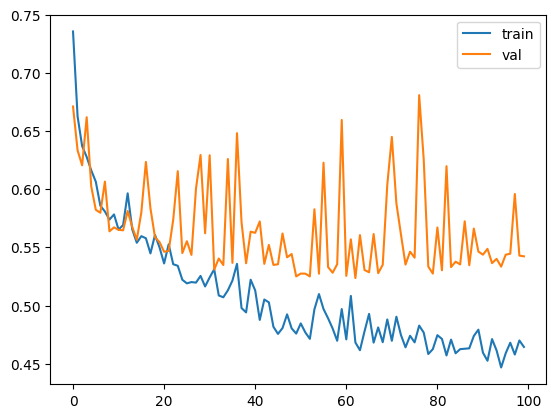

In [288]:
plt.plot(history_CNN.history['loss'], label='train')
plt.plot(history_CNN.history['val_loss'], label='val')
plt.legend()

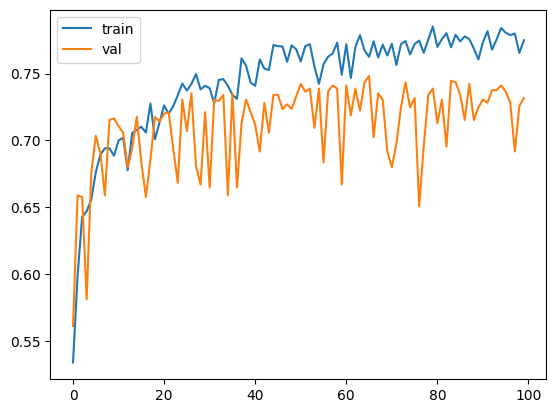

In [289]:
plt.plot(history_CNN.history['accuracy'], label='train')
plt.plot(history_CNN.history['val_accuracy'], label='val')
plt.legend()

In [290]:
CNN_model.evaluate(np.array(np.expand_dims(X_test,-1)),np.array(y_test))

24/24 [==============================] - 1s 33ms/step - loss: 0.5428 - accuracy: 0.7333


[0.5427696108818054, 0.7333333492279053]

**MLP**

In [274]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense


In [275]:
MLP_MODEL = Sequential()
MLP_MODEL.add(Input(768,1))
MLP_MODEL.add(Dense(200, activation='relu'))
MLP_MODEL.add(Dense(100, activation='relu'))
MLP_MODEL.add(Dense(20, activation='relu'))
MLP_MODEL.add(Dense(2, activation='softmax'))

In [298]:
MLP_MODEL.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (1, 200)                  153800    
                                                                 
 dense_21 (Dense)            (1, 100)                  20100     
                                                                 
 dense_22 (Dense)            (1, 20)                   2020      
                                                                 
 dense_23 (Dense)            (1, 2)                    42        
                                                                 
Total params: 175,962
Trainable params: 175,962
Non-trainable params: 0
_________________________________________________________________


In [276]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path + 'MLP', monitor='val_loss', save_best_only=True, save_feq='epoch')
MLP_MODEL.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_MLP = MLP_MODEL.fit(np.array(X_train),np.array(y_train), epochs=200, verbose=1, validation_split=0.2,callbacks=[early_stopping,model_checkpoint])

Epoch 1/200
 93/107 [=========================>....] - ETA: 0s - loss: 13.3296 - accuracy: 0.8044

INFO:tensorflow:Assets written to: PhoBert\MLP\assets


INFO:tensorflow:Assets written to: PhoBert\MLP\assets


107/107 [==============================] - 2s 11ms/step - loss: 12.9924 - accuracy: 0.8138 - val_loss: 9.3042 - val_accuracy: 0.8894
Epoch 2/200
107/107 [==============================] - 0s 4ms/step - loss: 8.9391 - accuracy: 0.8856 - val_loss: 10.5156 - val_accuracy: 0.8588
Epoch 3/200
107/107 [==============================] - 0s 4ms/step - loss: 7.5681 - accuracy: 0.9100 - val_loss: 10.0759 - val_accuracy: 0.8741
Epoch 4/200
106/107 [============================>.] - ETA: 0s - loss: 6.1631 - accuracy: 0.9295

INFO:tensorflow:Assets written to: PhoBert\MLP\assets


INFO:tensorflow:Assets written to: PhoBert\MLP\assets


107/107 [==============================] - 1s 10ms/step - loss: 6.1506 - accuracy: 0.9297 - val_loss: 8.9952 - val_accuracy: 0.8859
Epoch 5/200
107/107 [==============================] - 0s 4ms/step - loss: 4.2471 - accuracy: 0.9503 - val_loss: 9.2572 - val_accuracy: 0.8953
Epoch 6/200
107/107 [==============================] - 0s 4ms/step - loss: 3.5581 - accuracy: 0.9600 - val_loss: 9.6017 - val_accuracy: 0.9035
Epoch 7/200
107/107 [==============================] - 0s 5ms/step - loss: 2.5569 - accuracy: 0.9741 - val_loss: 10.9095 - val_accuracy: 0.8906
Epoch 8/200
107/107 [==============================] - 0s 4ms/step - loss: 2.3353 - accuracy: 0.9762 - val_loss: 10.5482 - val_accuracy: 0.8976
Epoch 9/200
107/107 [==============================] - 0s 4ms/step - loss: 1.6356 - accuracy: 0.9821 - val_loss: 13.4422 - val_accuracy: 0.8906
Epoch 10/200
107/107 [==============================] - 0s 4ms/step - loss: 0.6959 - accuracy: 0.9935 - val_loss: 16.9713 - val_accuracy: 0.8824
Epoch

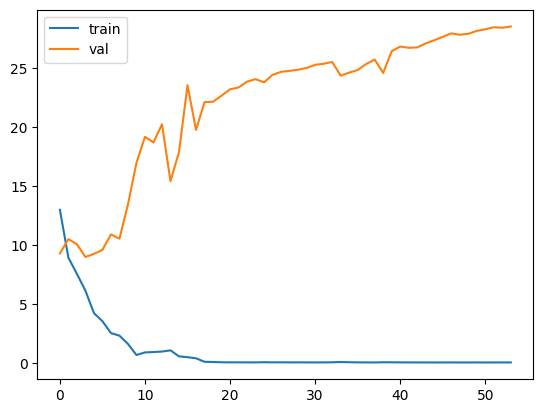

In [277]:
plt.plot(history_MLP.history['loss'], label='train')
plt.plot(history_MLP.history['val_loss'], label='val')
plt.legend()

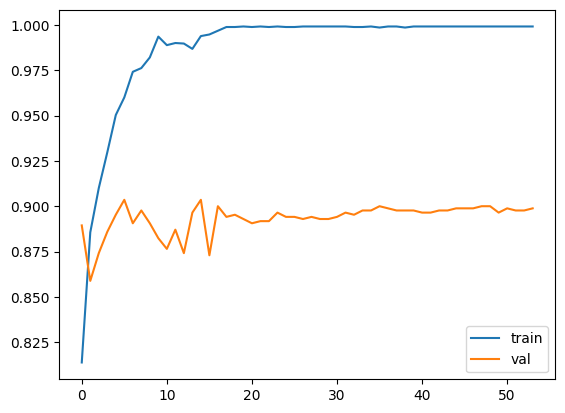

In [278]:
plt.plot(history_MLP.history['accuracy'], label='train')
plt.plot(history_MLP.history['val_accuracy'], label='val')
plt.legend()

In [279]:
MLP_MODEL.evaluate(np.array(np.expand_dims(X_test,-1)),np.array(y_test))

24/24 [==============================] - 0s 3ms/step - loss: 9.8637 - accuracy: 0.8907


[9.863667488098145, 0.890666663646698]

In [281]:
model_LSTM.save('model_MLP_DS307.h5')